In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Force Field Module

I'm developing a Python Module named ``forcefield`` to calculate the motion of particles in space given complex, changing forces on them.

For the purposes of this module, a [force field](https://en.wikipedia.org/wiki/Force_field_%28physics%29) is a system in which there is a function $\mathbf{F}(\mathbf{x})$ defining the force on a particle at any vector position $\mathbf{x}$ at a given point in time. The function can be quite complex and computationally expensive, and may depend on the positions of all other objects in the system at that time. Systems like this include multi-body gravitational systems, systems of connected masses and springs, charged particles, etc.

The goal is to calculate the position $\mathbf{x}(t)$ over time of each particle in the system, minimizing the number of times the function $\mathbf{F}(\mathbf{x})$ is evaluated while still preserving acceptable accuracy, so that we can simulate a larger number of particles.

## Interpolation of force when moving a mass from one location to another

In order to calculate the position $\mathbf{x}(t)$ of a particle over a short duration of time $\Delta{t}$, I estimate the force on that particle over time given two samples of the force on that particle:

$\mathbf{F}(t) = \mathbf{F_0} + \frac{\mathbf{x}(t) - \mathbf{x_0}}{\mathbf{x_1} - \mathbf{x_0}}(\mathbf{F_1} - \mathbf{F_0})$

Where:
* $\mathbf{F_0}$ is the force at the starting point $\mathbf{x_0}$ at time $t = 0$
* $\mathbf{F_1}$ is the force at the ending point $\mathbf{x_1}$ at time $t = \Delta{t}$
* $\mathbf{x}(t)$ is the position at time $0 <= t <= \Delta{t}$

Since $\mathbf{x}(t)$ is the function we are trying to calculate, we simplify the estimation of force over time like this:

$\mathbf{F}(t) = \mathbf{F_0} + \frac{\mathbf{F_1} - \mathbf{F_0}}{\Delta t} t$

where $\Delta t$ is the duration of the time step.

You might ask, if $\mathbf{x_1} = \mathbf{x}(\Delta{t})$ is not yet known, how do you know what $\mathbf{F_1} = \mathbf{F}(\mathbf{x_1})$ is? I determine $\mathbf{F_1}$ by an iterative process. I make an initial estimate by assuming that $\mathbf{F_0} = \mathbf{F_1}$ (or in other words, assuming the force remains constant). I calculate an estimated value for $\mathbf{x_1}$ given that assumption, then plug that estimated $\mathbf{x_1}$ value into our given force field function $\mathbf{F}(\mathbf{x_1})$ to get a more realistic value for $\mathbf{F_1}$. That process can be repeated to refine the accuracy.

## Frictionless motion through the force field

$\mathbf{v}(\Delta t) = \mathbf{v_0} + \frac{1}{m} \int_{0}^{\Delta t}{\mathbf{F}(t) dt}$

$\mathbf{x}(\Delta t) = \mathbf{x_0} + \int_{0}^{\Delta t}{\mathbf{v}(t) dt}$

where $m$ is the mass of the object of interest, $\mathbf{v_0}$ is the velocity of the object at time $t = 0$, and all other variables are as defined above.

Since $\mathbf{F}(t)$ is a polynomial, this expression can be integrated for any function of force that I come up with. So instead of simple linear interpolation, I can use the known $\frac{d\mathbf{F}(t)}{dt}$ and generate a quadratic equation for $\mathbf{F}(t)$, for example.

I can generate any polynomial and ``numpy`` will integrate it for me. Here's an example of integrating $ax^2 + bx + c$:

In [2]:
import numpy as np
from numpy.polynomial import Polynomial as P
a = 1.0
b = 2.0
c = 3.0
poly = P([c, b, a])
print(poly)
ipoly = poly.integ(k=0.0)
print(ipoly)
print(ipoly(0.5))

poly([ 3.  2.  1.])
poly([ 0.          3.          1.          0.33333333])
1.79166666667


## Motion of mass through force field with damping force proportional to velocity

$m \frac{d^2\mathbf{x}}{dt^2} + R \frac{d\mathbf{x}}{dt} = \mathbf{F}(t)$

where $R$ is the resistance and $\mathbf{F}(t)$ is the force due to the "field" at time $t$.

I went to [a web site describing Variation of Parameters](http://tutorial.math.lamar.edu/Classes/DE/VariationofParameters.aspx) at [Paul's Online Math Notes](http://tutorial.math.lamar.edu/) (highly recommended) to refresh myself on how to solve this differential equation.

First I had to get the equation into the form:

$y'' + q(t)y' + r(t)y = g(t)$

I did this by dividing both sides by $m$.

$\frac{d^2\mathbf{x}}{dt^2} + \frac{R}{m} \frac{d\mathbf{x}}{dt} = \frac{1}{m} \mathbf{F}(t)$

Given the initial approximation of $\mathbf{F}(t) = \mathbf{F_0}$, I got these equations for position and velocity:

$
\mathbf{x}(t) =
    \mathbf{x_0} + \frac{\mathbf{F_0}}{R}t + \frac{m}{R}(\mathbf{v_0} - \frac{\mathbf{F_0}}{R})(1 - e^{-\frac{R}{m}t})
$

$
\mathbf{v}(t) = \mathbf{v_0}e^{-\frac{R}{m}t} + \frac{\mathbf{F_0}}{R}(1 - e^{-\frac{R}{m}t})
$

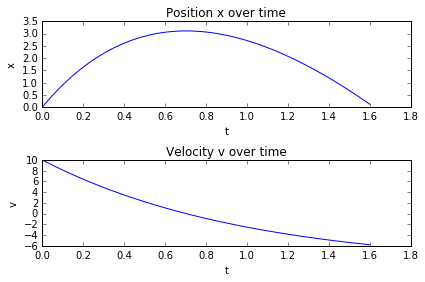

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

m = 1.0  # kg
R = 1.0  # kg / s
F0 = -9.8 * m  # kg * m / s^2
x0 = 0  # m
v0 = 10.0  # m / s
delta_t = 1.6  # s
t = np.linspace(0.0, delta_t, 100+1)
x = x0 + F0*t/R + (m/R)*(v0 - F0/R)*(1 - np.exp(-R*t/m))
v = v0*np.exp(-R*t/m) + (F0/R)*(1 - np.exp(-R*t/m))

fig = plt.figure()
nrows, ncols = 2, 1

ax1 = fig.add_subplot(nrows, ncols, 1)
ax1.set_title("Position x over time")
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.plot(t, x)

ax2 = fig.add_subplot(nrows, ncols, 2)
ax2.set_title("Velocity v over time")
ax2.set_xlabel("t")
ax2.set_ylabel("v")
ax2.plot(t, v)

fig.tight_layout()